## 「ベイズ推論による機械学習入門」
##   P.145 ガウス混合モデルに対するギブスサンプリング

In [238]:
using Distributions
using LinearAlgebra
using Plots
using Random
using PDMats

Random.seed!(1234); # 再現性のためシードを設定

## 真のモデル

In [43]:
D = 2
K = 3

μ₁_true = [5.0; 35.0]
μ₂_true = [-20.0; 10.0]
μ₃_true = [30.0; -20.0]

Σ₁_true = [
    250.0 65.0
    65.0 270.0
]

Σ₂_true = [
    125.0 -45.0
    -45.0 175.0
]

Σ₃_true = [
    210.0 -15.0
    -15.0 250.0
]

π_true = [0.45, 0.25, 0.3]

mult_gauss_true = MvNormal[
    MvNormal(μ₁_true, Σ₁_true), 
    MvNormal(μ₂_true, Σ₂_true), 
    MvNormal(μ₃_true, Σ₃_true)
]

true_model = MixtureModel(mult_gauss_true, π_true)

MixtureModel{MvNormal}(K = 3)
components[1] (prior = 0.4500): FullNormal(
dim: 2
μ: [5.0, 35.0]
Σ: [250.0 65.0; 65.0 270.0]
)

components[2] (prior = 0.2500): FullNormal(
dim: 2
μ: [-20.0, 10.0]
Σ: [125.0 -45.0; -45.0 175.0]
)

components[3] (prior = 0.3000): FullNormal(
dim: 2
μ: [30.0, -20.0]
Σ: [210.0 -15.0; -15.0 250.0]
)



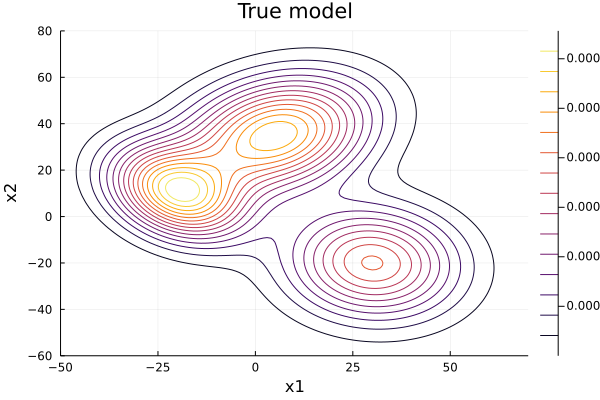

In [44]:
contour(-50:70, -60:80, (x, y) -> pdf(true_model, [x, y]), title="True model", xlabel="x1", ylabel="x2")

## 観測データの生成

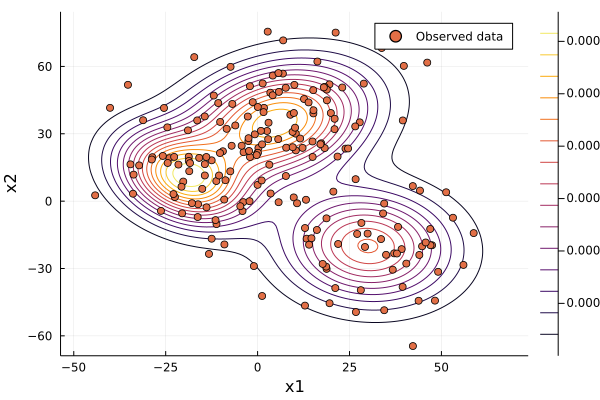

In [45]:
N = 200
mult_obs = Multinomial(1, π_true)
S_obs = rand(mult_obs, N)
cluster_num = mapslices(argmax, S_obs, dims=1)

μ_obs = [
    [μ₁_true]
    [μ₂_true]
    [μ₃_true]
]

Σ_obs = [
    [Σ₁_true]
    [Σ₂_true]
    [Σ₃_true]
]

data = zeros(D, N)
for n in 1:N
    k = cluster_num[n]
    mult_gauss_obs = MvNormal(μ_obs[k], Σ_obs[k])
    data[:, n] = rand(mult_gauss_obs)
end

contour(-50:70, -60:80, (x, y) -> pdf(true_model, [x, y]), xlabel="x1", ylabel="x2")
scatter!(data[1, :], data[2, :], label="Observed data")

クラスターごとに色を変えて表示する。

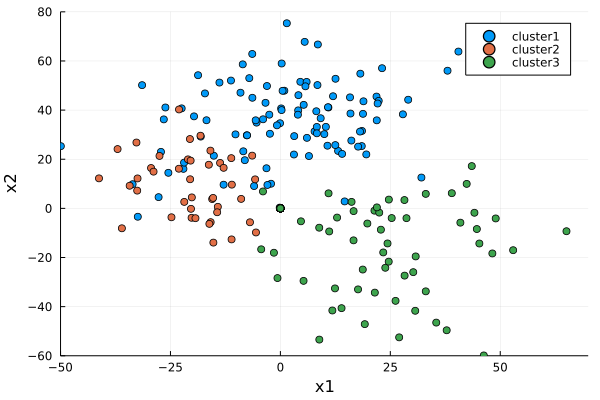

In [46]:
each_cluster = [zeros(D, N), zeros(D, N), zeros(D, N)]
for n in 1:N
    k = cluster_num[n]
    mult_gauss_obs = MvNormal(μ_obs[k], Σ_obs[k])
    each_cluster[k][:, n] = rand(mult_gauss_obs) 
end

p = plot(xlabel="x1", ylabel="x2", xlim=(-50,70), ylim=(-60,80))
for k in 1:K
    scatter!(p, each_cluster[k][1, :], each_cluster[k][2, :], label="cluster$k")
end
p

## ギブスサンプリング

In [462]:
N = 200
D = 2
K = 3
max_iter = 100

β_sample = zeros(max_iter + 1, K)
m_sample = zeros(D, K, max_iter + 1)
ν_sample = zeros(max_iter + 1, K)
W_sample = zeros(D, D, K, max_iter + 1)
α_sample = zeros(max_iter + 1, K)

μ_sample = zeros(K, D, max_iter + 1)
Λ_sample = zeros(D, D, K, max_iter + 1)
π_sample = zeros(max_iter + 1, K)

# 事前分布のパラメータの初期値を設定
β_sample[1, :] = ones(K)
ν_sample[1, :] = [2.0; 2.0; 2.0]
α_sample[1, :] = ones(K)

for k in 1:K
    W_sample[:, :, k, 1] = Matrix{Float64}(I, D, D)
end

### パラメータ$\boldsymbol \Lambda$、$\boldsymbol \alpha$のサンプルに初期値を設定

In [464]:
for k in 1:K
    wis = Wishart(ν_sample[1, k], W_sample[:, :, k, 1])
    Λ_sample[:, :, k, 1] = rand(wis)
end

Λ_sample

2×2×3×101 Array{Float64, 4}:
[:, :, 1, 1] =
  0.341182  -0.647638
 -0.647638   1.49715

[:, :, 2, 1] =
  3.30401    -0.0226256
 -0.0226256   0.467352

[:, :, 3, 1] =
  0.343307  -0.749196
 -0.749196   1.67925

[:, :, 1, 2] =
 0.0  0.0
 0.0  0.0

[:, :, 2, 2] =
 0.0  0.0
 0.0  0.0

[:, :, 3, 2] =
 0.0  0.0
 0.0  0.0

[:, :, 1, 3] =
 0.0  0.0
 0.0  0.0

[:, :, 2, 3] =
 0.0  0.0
 0.0  0.0

[:, :, 3, 3] =
 0.0  0.0
 0.0  0.0

...

[:, :, 1, 99] =
 0.0  0.0
 0.0  0.0

[:, :, 2, 99] =
 0.0  0.0
 0.0  0.0

[:, :, 3, 99] =
 0.0  0.0
 0.0  0.0

[:, :, 1, 100] =
 0.0  0.0
 0.0  0.0

[:, :, 2, 100] =
 0.0  0.0
 0.0  0.0

[:, :, 3, 100] =
 0.0  0.0
 0.0  0.0

[:, :, 1, 101] =
 0.0  0.0
 0.0  0.0

[:, :, 2, 101] =
 0.0  0.0
 0.0  0.0

[:, :, 3, 101] =
 0.0  0.0
 0.0  0.0

In [465]:
dir = Dirichlet(α_sample[1, :])
π_sample[1, :] = rand(dir)

π_sample

101×3 Matrix{Float64}:
 0.469209  0.196403  0.334387
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 ⋮                   
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0

### パラメータ$\boldsymbol \mu$のサンプルに初期値を設定

In [466]:
for k in 1:K
    mult_gauss = MvNormal(m_sample[:, k, 1], PDMat(Symmetric(inv(β_sample[1, k] * Λ_sample[:, :, k, 1]))))
    μ_sample[k, :, 1] = rand(mult_gauss)
end

μ_sample

3×2×101 Array{Float64, 3}:
[:, :, 1] =
 -11.215     -3.478
  -0.508768   1.1507
   2.28336   -0.297502

[:, :, 2] =
 0.0  0.0
 0.0  0.0
 0.0  0.0

[:, :, 3] =
 0.0  0.0
 0.0  0.0
 0.0  0.0

...

[:, :, 99] =
 0.0  0.0
 0.0  0.0
 0.0  0.0

[:, :, 100] =
 0.0  0.0
 0.0  0.0
 0.0  0.0

[:, :, 101] =
 0.0  0.0
 0.0  0.0
 0.0  0.0

### 潜在変数の事後分布のパラメータ$\boldsymbol \eta$の計算

In [467]:
η_ = zeros(N, K)
for n in 1:N
    for k in 1:K
        η_[n, k] = (data'[n, :] - μ_sample[k, :, 1])' * Λ_sample[:, :, k, 1] * (data'[n, :] - μ_sample[k, :, 1])
                    + 0.5 * log(det(Λ_sample[:, :, k, 1]))
                    + log(π_sample[1, k])
    end
end

η_

200×3 Matrix{Float64}:
  241.616     614.875     164.633
 1196.96     1993.99     1638.02
  904.259     768.377    1200.83
 1039.24     2028.91     1441.41
  799.268    3139.32      975.997
  549.723     804.199     447.711
   98.6009    617.867      27.1626
 1352.56     2300.36     1830.54
 7387.41     2826.71     8990.84
 3103.65     1082.77     3881.38
   59.558      18.1222    123.582
 1040.54      407.425    1426.24
 2339.2       775.727    2977.34
    ⋮                    
 2045.34     1512.27     2570.38
 1719.63     1016.42     2198.47
 2286.46     1668.63     2199.94
  460.959    1279.09      611.203
 1114.39      828.359    1460.91
  162.673    1598.27      296.68
    5.26258     9.92546     8.87379
  212.524    1658.01      367.58
  299.081    1364.13      488.607
 2100.7      1516.08     2006.82
 1408.51     1872.2      1277.31
 2757.53     6886.15     3236.27

In [468]:
η = η_ ./ sum(η_, dims=2)　# 正規化

200×3 Matrix{Float64}:
 0.236618   0.602155   0.161228
 0.247871   0.412923   0.339207
 0.314693   0.267404   0.417903
 0.230452   0.449913   0.319635
 0.162632   0.638777   0.198592
 0.305125   0.446372   0.248503
 0.132594   0.830879   0.036527
 0.246662   0.419509   0.333829
 0.384662   0.147187   0.468152
 0.384696   0.134209   0.481096
 0.295922   0.0900425  0.614035
 0.362027   0.141752   0.496221
 0.383962   0.12733    0.488709
 ⋮                     
 0.333771   0.246781   0.419449
 0.34849    0.205982   0.445528
 0.371478   0.2711     0.357422
 0.196048   0.544004   0.259948
 0.327409   0.243374   0.429217
 0.0790588  0.776756   0.144186
 0.218711   0.412498   0.368791
 0.0949569  0.740806   0.164237
 0.13899    0.633943   0.227067
 0.373551   0.269592   0.356856
 0.309018   0.410748   0.280234
 0.214095   0.534641   0.251264

### 潜在変数$\boldsymbol S$の事後分布をサンプリング

In [469]:
s_sample = zeros(N, K)
for n in 1:N
    cat = Multinomial(1, η[n, :])
    s_sample[n, :] = rand(cat)
end

s_sample

200×3 Matrix{Float64}:
 0.0  1.0  0.0
 1.0  0.0  0.0
 0.0  0.0  1.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0
 0.0  1.0  0.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 1.0  0.0  0.0
 ⋮         
 1.0  0.0  0.0
 1.0  0.0  0.0
 0.0  0.0  1.0
 0.0  1.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 1.0  0.0  0.0
 0.0  0.0  1.0
 0.0  0.0  1.0
 0.0  1.0  0.0
 1.0  0.0  0.0

### パラメータ$\boldsymbol \mu$の事後分布のパラメータを計算

In [470]:
β_sample[2, :] = sum(s_sample, dims=1) + β_sample[1, :]'

β_sample

101×3 Matrix{Float64}:
  1.0   1.0   1.0
 70.0  76.0  57.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  ⋮          
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0

In [471]:
for k in 1:K
    m_sample[:, k, 2] = (sum(s_sample[n, k] * data'[n, :] for n in 1:N) + β_sample[1, k] * m_sample[:, k, 1]) ./ β_sample[2, k]
end

m_sample

2×3×101 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
  4.86469  11.0739    3.67357
 19.0915    8.42607  15.2828

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0

...

[:, :, 99] =
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 100] =
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 101] =
 0.0  0.0  0.0
 0.0  0.0  0.0

### パラメータ$\boldsymbol \Lambda$の事後分布のパラメータを計算

In [472]:
ν_sample[2, :] = sum(s_sample, dims=1) + ν_sample[1, :]'

ν_sample

101×3 Matrix{Float64}:
  2.0   2.0   2.0
 71.0  77.0  58.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  ⋮          
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0

In [475]:
for k in 1:K
    W_sample[:, :, k, 2] = inv(sum(s_sample[n, 1] * data'[n, :] * data[:, n]' for n in 1:N)
                           + β_sample[1, 1] * m_sample[:, 1, 1] * m_sample[:, 1, 1]'
                           - β_sample[2, 1] * m_sample[:, 1, 2] .* m_sample[:, 1, 2]'
                           + inv(W_sample[:, :, k, 1]))
end

W_sample[:, :, :, 2]

2×2×3 Array{Float64, 3}:
[:, :, 1] =
 4.17735e-5  9.36633e-6
 9.36633e-6  1.78557e-5

[:, :, 2] =
 4.17735e-5  9.36633e-6
 9.36633e-6  1.78557e-5

[:, :, 3] =
 4.17735e-5  9.36633e-6
 9.36633e-6  1.78557e-5

### パラメータ$\boldsymbol \Lambda$の事後分布をサンプリング

In [478]:
for k in 1:K
    wis = Wishart(ν_sample[2, k], W_sample[:, :, k, 2])
    Λ_sample[:, :, k, 2] = rand(wis)
end

Λ_sample

2×2×3×101 Array{Float64, 4}:
[:, :, 1, 1] =
  0.341182  -0.647638
 -0.647638   1.49715

[:, :, 2, 1] =
  3.30401    -0.0226256
 -0.0226256   0.467352

[:, :, 3, 1] =
  0.343307  -0.749196
 -0.749196   1.67925

[:, :, 1, 2] =
 0.0023374    0.000834544
 0.000834544  0.00129377

[:, :, 2, 2] =
 0.00316451   0.000898396
 0.000898396  0.00144632

[:, :, 3, 2] =
 0.00296622   0.000910344
 0.000910344  0.000995897

[:, :, 1, 3] =
 0.0  0.0
 0.0  0.0

[:, :, 2, 3] =
 0.0  0.0
 0.0  0.0

[:, :, 3, 3] =
 0.0  0.0
 0.0  0.0

...

[:, :, 1, 99] =
 0.0  0.0
 0.0  0.0

[:, :, 2, 99] =
 0.0  0.0
 0.0  0.0

[:, :, 3, 99] =
 0.0  0.0
 0.0  0.0

[:, :, 1, 100] =
 0.0  0.0
 0.0  0.0

[:, :, 2, 100] =
 0.0  0.0
 0.0  0.0

[:, :, 3, 100] =
 0.0  0.0
 0.0  0.0

[:, :, 1, 101] =
 0.0  0.0
 0.0  0.0

[:, :, 2, 101] =
 0.0  0.0
 0.0  0.0

[:, :, 3, 101] =
 0.0  0.0
 0.0  0.0

### パラメータ$\boldsymbol \mu$の事後分布をサンプリング

In [494]:
for k in 1:K
    mult_gauss = MvNormal(m_sample[:, k, 2], PDMat(Symmetric(inv(β_sample[2, k] * Λ_sample[:, :, k, 2]))))
    μ_sample[k, :, 2] = rand(mult_gauss)
end

μ_sample[:, :, 1:3]

3×2×3 Array{Float64, 3}:
[:, :, 1] =
 -11.215     -3.478
  -0.508768   1.1507
   2.28336   -0.297502

[:, :, 2] =
  8.87067   14.216
 11.7622     2.59409
  0.541319  18.657

[:, :, 3] =
 0.0  0.0
 0.0  0.0
 0.0  0.0

### 混合比率の事後分布のパラメータ$\boldsymbol \alpha$を計算

In [503]:
α_sample[2, :] = sum(s_sample, dims=1) + α_sample[1, :]'

α_sample

101×3 Matrix{Float64}:
  1.0   1.0   1.0
 70.0  76.0  57.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  ⋮          
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0
  0.0   0.0   0.0

### 混合比率$\boldsymbol \pi$の事後分布をサンプリング

In [506]:
dir = Dirichlet(α_sample[2, :])
π_sample[2, :] = rand(dir)

π_sample

101×3 Matrix{Float64}:
 0.469209  0.196403  0.334387
 0.319778  0.437508  0.242714
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 ⋮                   
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0
 0.0       0.0       0.0